<a href="https://colab.research.google.com/github/MarcosMT96/data/blob/main/PRF_Flowers_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=1x-QAgitB-S5rxGGDqxsJ299ZQTfYtOhb" width=180, align="center"/>

Máster Universitario en Sistemas Inteligentes

Asignatura: 11754 - Aprendizaje profundo

Curso: 2021-2022

Autor: Miguel Ángel Calafat Torrens

# PRÁCTICA FINAL EVALUADA

Objetivos:
* Creación y entrenamiento de una red neuronal profunda desde cero para identificar diferentes especies de flores.

* Entrenamiento de una red neuronal convolucional profunda pre-entrenada haciendo uso del aprendizaje por transferencia.


## Montar la unidad en tu Drive

A continuación hay que montar la unidad de tu Google Drive para poder acceder a ella desde este _notebook_

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Ahora lista el directorio en el que se encuentra este notebook. Puedes hacerlo con:
`%cd my_path`

In [ ]:
# Por ejemplo:
# %cd '/content/gdrive/MyDrive/Colab Notebooks/Flowers'
%cd '/content/gdrive/MyDrive/Colab Notebooks/Flowers'
%ls -l

/content/gdrive/MyDrive/Colab Notebooks/Flowers
total 606727
-rw------- 1 root root      2218 Dec  7  2021 cat_to_name.json
drwx------ 2 root root      4096 Jun 13 16:30 flower_data/
-rw------- 1 root root      1748 Jan 20 22:44 helpers.py
-rw------- 1 root root 309219706 Jun 15 11:12 model_scratch2.pt
-rw------- 1 root root 309219450 Jun 15 08:58 model_scratch.pt
-rw------- 1 root root      8815 Jun 15 09:16 model_scratch_tr_data.var
-rw------- 1 root root   1791547 Jun 15 08:17 PRF-Flowers_2.ipynb
-rw------- 1 root root    230353 Jun 14 16:21 PRF-Flowers.ipynb
drwx------ 2 root root      4096 Jun 13 17:42 __pycache__/
-rw------- 1 root root    803364 Jun 15 16:20 TransferLearning.ipynb


En la salida de la celda anterior deberías ver un listado de todos los archivos y carpetas de tu carpeta de proyecto.

In [ ]:
# Aquí se inserta al path de python el path de la carpeta de proyecto, en la que
# está este archivo.
import pathlib
import sys

PROJECT_DIR = str(pathlib.Path().resolve())
sys.path.append(PROJECT_DIR)

## Instalación de pytorch
Pytorch y torchvision vienen instalados por defecto. Ejecuta la celda siguiente para comprobar qué versiones están instaladas.

Esto puede ser de utilidad si en el futuro necesitas saber con qué versión de las librerías realizaste el trabajo.


In [ ]:
import torch
import torchvision
print('Torch version: {}'.format(torch.__version__))
print('Torchvision version: {}'.format(torchvision.__version__))

Torch version: 1.11.0+cu113
Torchvision version: 0.12.0+cu113


## Importaciones de librerías

A continuación utiliza la celda siguiente para importar todas las librerías que vayas a usar, excepto las que ya han sido importadas. Puedes importar las librerías que quieras; pero asegúrate de que todas figuran en la celda siguiente. No debería haber importaciones posteriores.

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, models, datasets
from matplotlib import checkdep_ghostscript

import numpy as np
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt

import time
from datetime import timedelta
import json
import copy
from IPython.display import clear_output

import helpers as h

In [ ]:
startT = time.monotonic()
endT = time.monotonic()
print(timedelta(seconds=endT-startT))

0:00:00.000033


## Desarrollo del programa. Nueva red neuronal profunda desde cero.

In [ ]:
# XXX - EC01 - 0.5

# A continuación tienes la variable global TRAIN_ON_GPU que te indica si
# se puede entrenar sobre cuda o no. Define la variable global DEVICE que
# indique el dispositivo sobre el que se entrenará (cuda o cpu).
TRAIN_ON_GPU = torch.cuda.is_available()
# Start_________________________________________________________________________
DEVICE = torch.device('cuda' if TRAIN_ON_GPU else 'cpu')
# End___________________________________________________________________________

if TRAIN_ON_GPU:
    print('CUDA is available. Train on GPU.')
else:
    print('CUDA unavailable. Train on CPU.')    

CUDA is available. Train on GPU.


In [ ]:
# Establece las direcciones relevantes del proyecto como strings.
# Si has seguido las instrucciones en la carga del dataset, no deberías de hacer
# ninguna modificación en esta celda; basta ejecutarla.

train_dir = PROJECT_DIR + '/flower_data/train'
valid_dir = PROJECT_DIR + '/flower_data/valid'
test_dir = PROJECT_DIR + '/flower_data/test'

In [ ]:
# XXX - EC02 - 0.5

# Carga el archivo cat_to_name.json, que previamente habrás tenido que guardar
# en la carpeta del proyecto
# Start_________________________________________________________________________
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
# End___________________________________________________________________________

print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

Debería salir esto:
```
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 'sunflower', '66': 'osteospermum', '70': 'tree poppy', '85': 'desert-rose', '99': 'bromelia', '87': 'magnolia', '5': 'english marigold', '92': 'bee balm', '28': 'stemless gentian', '97': 'mallow', '57': 'gaura', '40': 'lenten rose', '47': 'marigold', '59': 'orange dahlia', '48': 'buttercup', '55': 'pelargonium', '36': 'ruby-lipped cattleya', '91': 'hippeastrum', '29': 'artichoke', '71': 'gazania', '90': 'canna lily', '18': 'peruvian lily', '98': 'mexican petunia', '8': 'bird of paradise', '30': 'sweet william', '17': 'purple coneflower', '52': 'wild pansy', '84': 'columbine', '12': "colt's foot", '11': 'snapdragon', '96': 'camellia', '23': 'fritillary', '50': 'common dandelion', '44': 'poinsettia', '53': 'primula', '72': 'azalea', '65': 'californian poppy', '80': 'anthurium', '76': 'morning glory', '37': 'cape flower', '56': 'bishop of llandaff', '60': 'pink-yellow dahlia', '82': 'clematis', '58': 'geranium', '75': 'thorn apple', '41': 'barbeton daisy', '95': 'bougainvillea', '43': 'sword lily', '83': 'hibiscus', '78': 'lotus lotus', '88': 'cyclamen', '94': 'foxglove', '81': 'frangipani', '74': 'rose', '89': 'watercress', '73': 'water lily', '46': 'wallflower', '77': 'passion flower', '51': 'petunia'}
```

In [ ]:
# XXX - EC03 - 1.0 Pregunta

# Define las transformaciones que vas a aplicar a los cojuntos de datos.
# Las dimensiones finales deben ser como mínimo 224 x 224.

# Start_________________________________________________________________________
# Normaliza según https://pytorch.org/vision/stable/models.html
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Aplica la composición de transformaciones a cada conjunto
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.2),transforms.RandomPerspective(distortion_scale=0.3, p=0.2),transforms.RandomRotation(10),transforms.Resize((264, 264)),
                                      transforms.CenterCrop((224, 224)),transforms.ToTensor(),normalizer])
valid_transform = transforms.Compose([transforms.Resize((264, 264)),transforms.CenterCrop((224, 224)),transforms.ToTensor(),normalizer])
test_transform = transforms.Compose([transforms.Resize((264, 264)),transforms.CenterCrop((224, 224)),transforms.ToTensor(),normalizer])
# End___________________________________________________________________________

**PREGUNTA sobre EC03 (1 punto):** Explica las transformaciones elegidas y el porqué de esta elección.

**Respuesta:** Se realiza una rotación en el eje horizontal lo que hace es poner lo que está a la derecha a la izquierda y lo contrario. Adicional se hace una transformación de perspectiva, se realiza una transformación de escala y luego se corta el centro. Esto solo se aplicó a los datos de entrenamiento. 
Los datos de validadción y transformación solo se realizó un escalado y luego un corte, para que todas las imágenes quedaran de 224*224

In [ ]:
# XXX - EC04 - 1.0

# Carga los conjuntos de datos. train_data, valid_data y test_data
# deberán ser objetos del tipo ImageFolder.

# Start_________________________________________________________________________
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
# End___________________________________________________________________________

In [ ]:
# XXX - EC05 - 1.0 Pregunta
# Define los objetos dataloader

# Start_________________________________________________________________________

# Número de subprocesos. Si estás trabajando en Google Colab, no modifiques este
# valor. Si estás trabajando en local, sin duda podrás encontrar otros valores
# que reduzcan el tiempo de entrenamiento.
num_workers = 2


# Selecciona el número de muestras de cada lote

MINIBATCH_SIZE = 102
# Define los objetos dataloader para entrenamiento, validación y test
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=MINIBATCH_SIZE,
                                           shuffle=True,
                                           num_workers=num_workers)
  #Validation Set
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=MINIBATCH_SIZE,
                                           shuffle=True,
                                           num_workers=num_workers)
  #Test set
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=MINIBATCH_SIZE, 
                                          shuffle=True,
                                          num_workers=num_workers)
# End___________________________________________________________________________

# Se guardan los dataloaders en un diccionario
loaders_scratch = {'train': train_loader,
                   'valid': valid_loader,
                   'test': test_loader}

Verificación del proceso

In [ ]:
#Verificación Data
train_data

Dataset ImageFolder
    Number of datapoints: 6552
    Root location: /content/gdrive/MyDrive/Colab Notebooks/Flowers/flower_data/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.2)
               RandomPerspective(p=0.2)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(264, 264), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
#Verificación Loada
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 6552
    Root location: /content/gdrive/MyDrive/Colab Notebooks/Flowers/flower_data/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.2)
               RandomPerspective(p=0.2)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(264, 264), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

La imagen muestreada representa un: 10


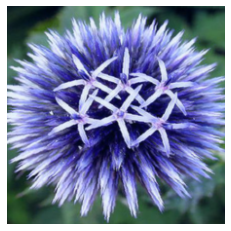

In [ ]:
#Verificación Imagen
classes = train_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(train_loader))
print(f'La imagen muestreada representa un: {classes[train_loader.dataset[rnd_sample_idx][1]]}')
image = train_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

In [ ]:
#Verificación Classes
dataset_sizes = len(train_data)+len(valid_data)+len(test_data)  
print("Dasaset Size: "+ str(dataset_sizes) + "\n") 
n_class = len(classes)  
print("Number of classes: "+ str(n_class) + "\n")  

Dasaset Size: 8189

Number of classes: 102



In [ ]:
# XXX - EC06 - 3.0

# Define la clase MyCNN a partir de nn.Module
# La clase deberá tener la función __init__ y la función forward


#Preguntar por los tamaños 
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Start_________________________________________________________________
        # Define las diferentes capas convolucionales, maxpool, etc.
        # Imagen entrada = 224*224*3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) #16* 224 * 224
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) #32* 112 * 112
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(2) 
        self.dropout = nn.Dropout(p=0.3)

        self.logsoftmax = nn.LogSoftmax(dim=1)

        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 102) #salida  
        # End___________________________________________________________________


    def forward(self, x):
        # Start_________________________________________________________________
        # Define el comportamiento de la red.
        # Imagen entrada = 224*224*3 -- Salida =224*224*16
        x = F.relu(self.bn1(self.conv1(x)))

        # Imagen entrada = 224*224*16 -- Salida =112*112*16
        x = self.maxpool(x)

        # Imagen entrada = 112*112*16 -- Salida =56*56*32
        x = self.maxpool(F.relu(self.bn2(self.conv2(x))))

        # Imagen entrada = 56*56*32 -- Salida =28*28*64
        x = self.maxpool(F.relu(self.bn3(self.conv3(x))))

        x = x.reshape(-1, 28 * 28 * 64)

        x = self.dropout(x)

        x = F.relu(self.fc1(x))

        x = self.logsoftmax(self.fc2(x))

        # End___________________________________________________________________

        return x

**PREGUNTA sobre EC06 (3 puntos):** Explica paso a paso qué ocurre con los tensores en tu función forward. Especifica las dimensiones de los tensores a la entrada y salida de cada capa.

**Respuesta:** Se inicia el proceso de convolución, para esto se definieron 3 convoluciones, cada una tiene un filtro de kernel 3*3. Esta convoluciones extraen información de la imagen aplicando diferentes filtros y creando nuevos canales. 
Cada convolucíon cuenta con un maxpool y una función relu.
Finalmente se reduce a un vector lineal y se aplica una funcion logsoftmax

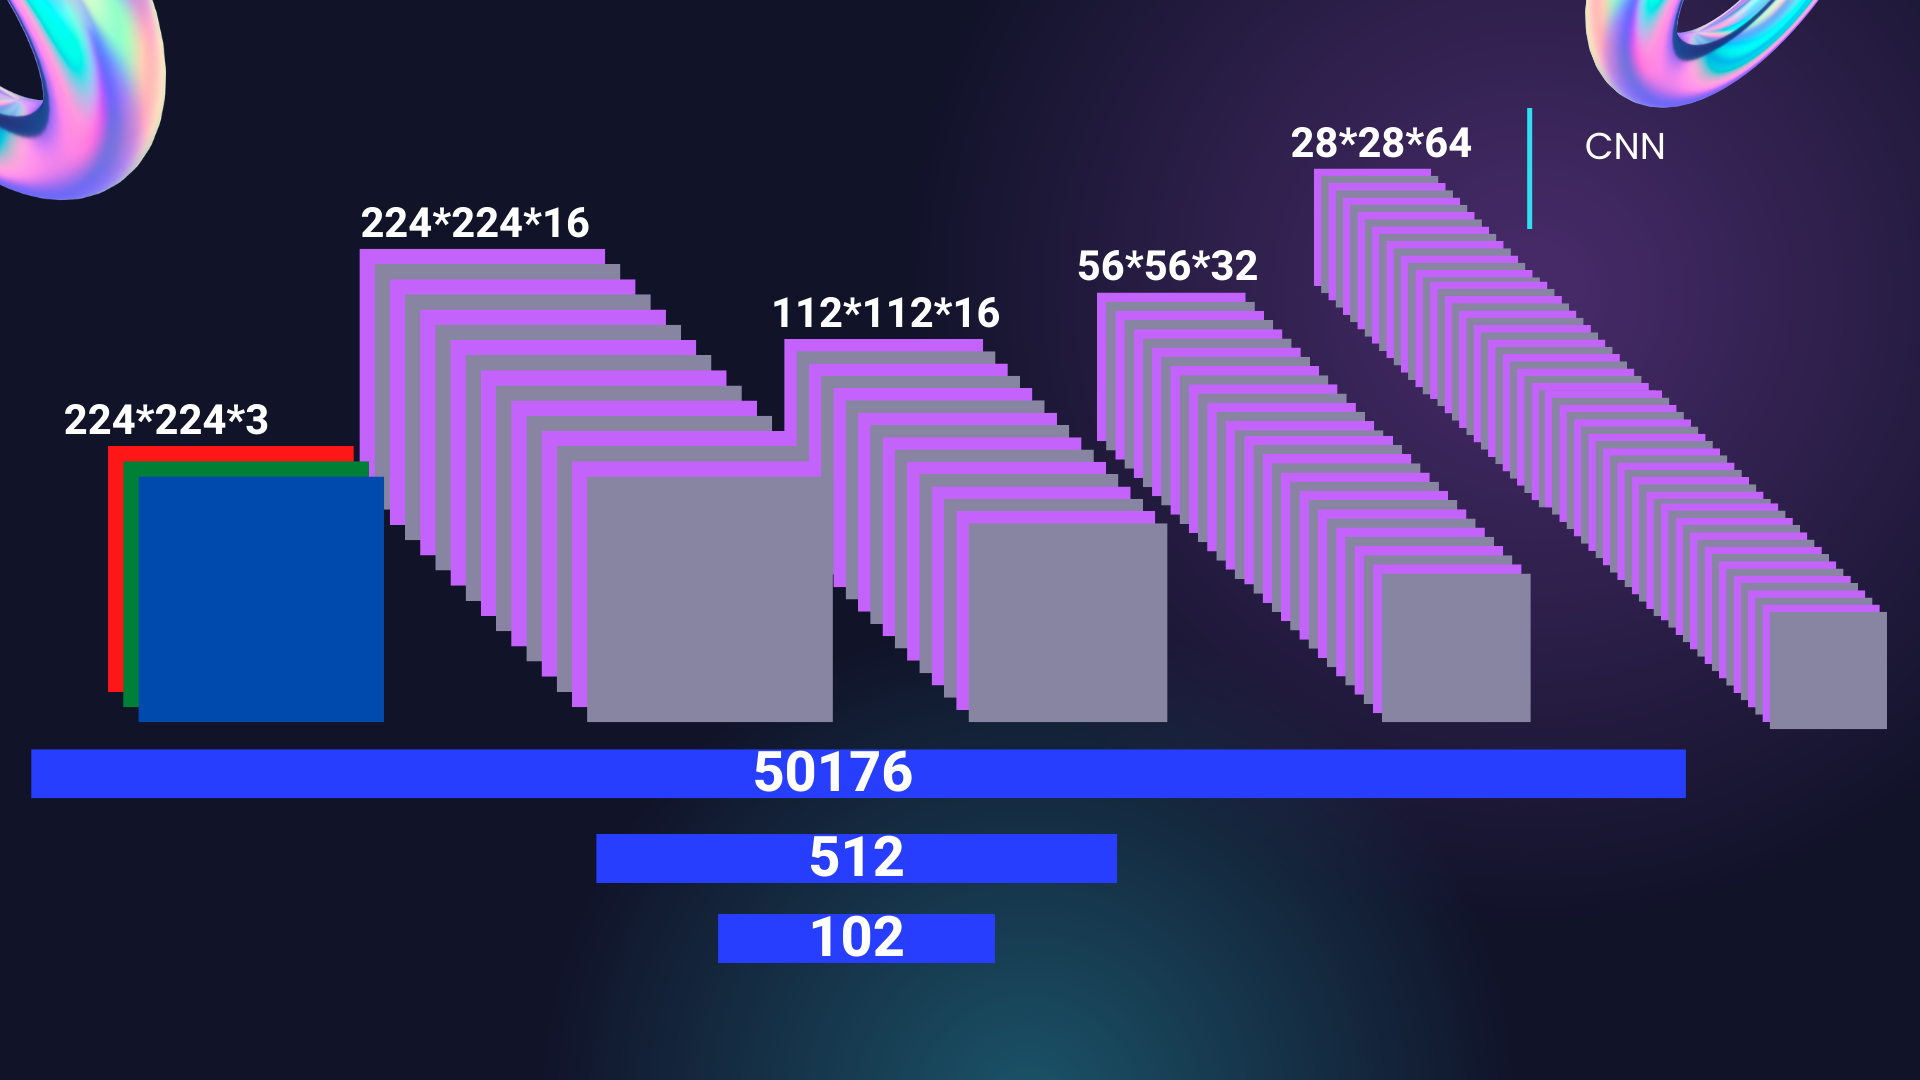

In [ ]:
# model_scratch será una instancia de la nueva clase definida
model_scratch = MyCNN()
 
# Se pasa el modelo a la GPU si es posible
model_scratch = model_scratch.to(DEVICE)
model_scratch2 = model_scratch
if TRAIN_ON_GPU:
    print("Model passed to GPU.")
else:
    print("Model remains on CPU.")

Model passed to GPU.


In [ ]:
# XXX - EC07 - 1.0

# Selecciona la función de pérdida  MSELoss()
# Start_________________________________________________________________________

criterion_scratch =  nn.NLLLoss()
# End___________________________________________________________________________

**PREGUNTA sobre EC07 (1 punto):** Justifica la selección anterior.

**Respuesta:** Utilizando la documentación, encontramos que es la función de perdida más adecuada para la capa de activación final que utiliza nuestro modelo.

In [ ]:
# XXX - EC08 - 1.0 Pregunta ¿Encontrar el Lr op?

# Selecciona el optimizador con su tasa de aprendizaje
# Start_________________________________________________________________________
lr = 0.002  # Learning rate F1:0.002 F2:0.0002 F3:0.005
#optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr)
optimizer_scratch = torch.optim.Adamax(model_scratch.parameters(), lr)
#optimizer_scratch = torch.optim.Adadelta(model_scratch.parameters(), lr=lr)
# End___________________________________________________________________________

**PREGUNTA sobre EC08 (1 punto):** Justifica la selección anterior.

**Respuesta:** Se testean varias funciones de activación. Encontrando en Adamax, la mas adecuada, dado que es capaz de manejar de forma más estable el ruido. Es una extensión de la versión de Adam del descenso de gradiente que generaliza el enfoque de la norma infinita (max) y puede dar como resultado una optimización más efectiva en algunos problemas.

A continuación tienes que completar la función de entrenamiento. Los nombres de los parámetros de entrada son bastante clarificadores de lo que se espera, ya que mantienen una nomenclatura coherente con el resto del documento visto hasta ahora. Aun así, se te presenta una breve descripción de cada uno:
 * `n_epochs`: Número de épocas a entrenar
 * `loaders`: Diccionario con los cargadores de datos de entrenamiento, validación y test.
 * `model`: El modelo de red neuronal.
 * `optimizer`: El objeto tipo optimizador.
 * `criterion`: La función de pérdida.
 * `filename`: El nombre con el que se quiere guardar el modelo.

Recuerda que tanto la variable `DEVICE` como `TRAIN_ON_GPU` son globales y puedes usarlas en cualquier celda de este cuaderno. Además, si quieres pasar más parámetros puedes hacerlo a través de las tuplas _args_ y _kwargs_.

In [ ]:
# XXX - EC09 - 5.0
# Construye la función de entrenamiento

def train(n_epochs, loaders, model, optimizer, criterion, filename='model.pt',
          *args, **kwargs):

    # Inicialización de valores de seguimiento del algoritmo
    valid_loss_min = np.Inf  # Pérdidas de validación iniciales
    record_list = []  # Esto es un registro de lo ocurrido
    tr_loss_list = []  # Lista de valores de training loss en cada época
    vl_loss_list = []  # Lista de valores de validation loss en cada época
    
    # Pon a continuación el tratamiento de los parámetros incluidos en 
    # args y kwargs (si los usas)
    # Start___________________________________________________________________

    # End_____________________________________________________________________

    # Cada época implica un barrido por todo el dataset, tanto de entrenamiento
    # como de validación
    for epoch in range(1, n_epochs+1):
        # Inicialización de variables de época actual
        start_time = time.time()  # Instante inicial
        train_loss = 0.0  # Pérdidas de entrenamiento
        valid_loss = 0.0  # Pérdidas de validación
        
        # Entrenamiento del modelo. Primero se pasa a modo train()
        model.train()
        
        # Programa el barrido de entrenamiento por cada lote con su forward pass,
        # su backward pass, sus pérdidas y todo lo que consideres oportuno
        # Start_________________________________________________________________
        # Barrido por cada batch de entrenamiento
        for data, target in loaders['train']:
            # Mensajes de seguimiento (opcional; puedes eliminarlo si quieres)
           
            # Pasa los tensores a GPU si procede
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Borra gradientes anteriores
            optimizer.zero_grad()
            # Calcula la salida del modelo (forward pass)
            output = model(data)
            # Calcula las pérdidas
            loss = criterion(output, target)
            # Calcula la propagación hacia atrás (back propagation).
            loss.backward()
            # Actualiza los parámetros del optimizador
            optimizer.step()
            # Registra las pérdidas en train_loss de forma que al final de la
            # época contenga el valor de las pérdidas promedio de todos los
            # lotes. Dependiendo de cómo hagas esto train_loss podría quedar
            # dentro o fuera del bucle for de entrenamiento
            train_loss += loss.item()
        # End_______________________________________________________________
            
        # Validación del modelo.
        # Primero se pasa al modo de evaluación. No hay entrenamiento como tal.
        model.eval()
        
        # Programa el barrido de validación por cada lote.
        # Start_________________________________________________________________
        # Barrido por cada lote de validación
        for data, target in loaders['valid']:
            # Pasa los tensores a GPU si procede
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Con el cálculo de gradientes deshabilitado, calcula la salida.
            with torch.no_grad():
              output = model(data)
            # Calcula la pérdida
            loss = criterion(output, target)
            # Registra las pérdidas en valid_loss de forma que al final de la
            # época contenga el valor de las pérdidas promedio de todos los
            # lotes. Dependiendo de cómo hagas esto valid_loss podría quedar
            # dentro o fuera del bucle for de validación
            valid_loss += loss.item()
        # End__________________________________________________________________
            
        # Se registran las estadísticas de entrenamiento y validación
        end_time = time.time()
        # Se registra el valor de las pérdidas de esta época en las listas
        # tr_loss_list y vl_loss_list
        tr_loss_list.append(train_loss)
        vl_loss_list.append(valid_loss)
        # Se registra el log de entrenamiento
        record_list.append('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f}   Time: {:.1f}'.format(
            epoch, train_loss, valid_loss, end_time - start_time))
        print(record_list[-1])
        
        # Se guarda el modelo si se tienen las menores pérdidas de validación
        #No la sé
        if valid_loss < valid_loss_min:
            # Start_____________________________________________________________
            # Realiza la grabación en disco del diccionario de estados state_dict
            custom_dict = {'model_state_dict': model.state_dict(),
                   'opt_state_dict': optimizer.state_dict(),
                   'tr_loss_list': tr_loss_list,
                   'vl_loss_list': vl_loss_list}
            torch.save(custom_dict, filename)
            valid_loss_min = valid_loss
            # Guarda una copia del mejor diccionario de estados en best_state_dict
            best_state_dict = copy.deepcopy(model.state_dict())
            # End_______________________________________________________________
            # Se actualizan parámetros y log
            message = 'Validation loss decreased from {:.6f} to {:.6f} in epoch {}. Saved!'.format(
                valid_loss_min, valid_loss, epoch)
            valid_loss_min = valid_loss
            record_list.append(message)
            print(record_list[-1])
    
    # Asegúrate que tienes en model el mejor modelo antes de salir. Esta función
    # tiene que retornar a la salida el modelo con el mejor ajuste de state_dict
    # Start_________________________________________________________________
    model.load_state_dict(best_state_dict)
    print('Checkpoint saved at epoch {}'.format(len(tr_loss_list)))
    # End___________________________________________________________________
    

    # Se devuelve el modelo entrenado y una tupla con datos del entrenamiento
    return model, (tr_loss_list, vl_loss_list, record_list, time.localtime())

In [ ]:
# Nombre con el que se grabará el modelo
ms_save_name = 'model_scratch.pt'

In [ ]:
# XXX - EC10 - 1.0


# Selecciona el número de épocas a entrenar y lanza el entrenamiento
# Start_________________________________________________________________________
startT = time.monotonic()
n_epochs = 70 #Testar con menos epocas
model_scratch, training_data = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch,filename=ms_save_name)
endT = time.monotonic()
print(timedelta(seconds=endT-startT))
# End___________________________________________________________________________

# Se guardan los datos del entrenamiento en la carpeta del proyecto. El nombre
# del fichero será el mismo que el del modelo, más el sufijo _tr_data.var.
# Este fichero .var tienes que entregarlo.
torch.save(training_data, ms_save_name.split('.')[0] + '_tr_data.var')

Epoch: 1  Training Loss: 890.166176  Validation Loss: 37.702523   Time: 423.5
Validation loss decreased from 37.702523 to 37.702523 in epoch 1. Saved!
Epoch: 2  Training Loss: 259.203676  Validation Loss: 34.391256   Time: 42.7
Validation loss decreased from 34.391256 to 34.391256 in epoch 2. Saved!
Epoch: 3  Training Loss: 229.683380  Validation Loss: 32.423035   Time: 42.8
Validation loss decreased from 32.423035 to 32.423035 in epoch 3. Saved!
Epoch: 4  Training Loss: 212.808177  Validation Loss: 30.100223   Time: 43.1
Validation loss decreased from 30.100223 to 30.100223 in epoch 4. Saved!
Epoch: 5  Training Loss: 199.196369  Validation Loss: 26.065653   Time: 42.4
Validation loss decreased from 26.065653 to 26.065653 in epoch 5. Saved!
Epoch: 6  Training Loss: 187.239174  Validation Loss: 25.668020   Time: 43.4
Validation loss decreased from 25.668020 to 25.668020 in epoch 6. Saved!
Epoch: 7  Training Loss: 177.840540  Validation Loss: 26.076762   Time: 43.4
Epoch: 8  Training Los

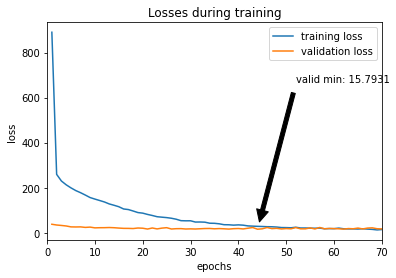

In [ ]:
# XXX - EC11 - 1.0

# Representa en una gráfica los datos de las pérdidas de entrenamiento y
# validación. Carga estos datos del archivo .var correspondiente si no has
# realizado el entrenamiento en esta sesión.
# Start_________________________________________________________________________
# Carga los datos de simulación (si procede)
x = range(1, 1 + len(training_data[0]))
tr_losses, vl_losses = training_data[0], training_data[1]
tr_max, tr_min = np.max(tr_losses), np.min(tr_losses)
epoch_min = 1 + np.argmin(vl_losses)
val_min = np.min(vl_losses)

plt.plot(x, training_data[0], label='training loss')
plt.plot(x, training_data[1], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Losses during training")
plt.legend()
plt.annotate('valid min: {:.4f}'.format(val_min), xy=(epoch_min, val_min),
             xytext=(round(0.75 * len(tr_losses)), 3*(tr_max - tr_min)/4 + tr_min),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.xlim(0, len(tr_losses))
plt.show()
# End___________________________________________________________________________

**PREGUNTA sobre EC11 (2 puntos):** Explica e interpreta la gráfica anterior.

**Respuesta:** La línea azul representa el error en el proceso de aprendizaje solo con los datos de entrenamiento. La línea naranja, reprensenta el error con los datos de validación. A medida que el modelo aprende, se reduce el error para los datos de entrenamiento. Podemos bajar la probabilidad del Dropout, dado que los datos de validación van mejor que los datos de entrenamiento, esto muestra que no se produce overfiting.

A continuación se va a realizar un test al modelo entrenado. Para ejecutar este test utilizarás la función test del archivo `helpers.py`.
Se espera que el modelo entrenado sea capaz de clasificar correctamente al menos el 70% de las imágenes. En caso contrario deberás mejorar tu modelo o entrenarlo mejor. Se puede realizar unas epocas más, dado que se está viendo como se mejora cada epoca.

In [ ]:

h.test(loaders_scratch, model_scratch,criterion_scratch, TRAIN_ON_GPU)

Test Loss: 2.454254

Test Accuracy: 55.3% (453/819)


{'accuracy': 55.311355311355314, 'test loss': 2.454253911972046}

In [ ]:
# Se libera espacio en la GPU
del model_scratch, optimizer_scratch
torch.cuda.empty_cache()

# Red neuronal profunda con aprendizaje por transferencia (modelo pre-entrenado)

Ahora vas a realizar los mismos ejercicios anteriores, pero en esta ocasión usando un modelo pre-entrenado.

In [ ]:

loaders_transfer = loaders_scratch

En la celda siguiente vas a cargar un modelo pre-entrenado. Investiga cuál te conviene. No hay una solución correcta, ya que muchos pueden servirte. Deberías poder llegar a valores en torno al 90% de aciertos en el test; pero no es un requisito. El objetivo es superar la precisión del modelo anterior.
Consulta la documentación en: [https://pytorch.org/vision/stable/models.html](https://pytorch.org/vision/stable/models.html)

In [ ]:

loaders_transfer = loaders_scratch

# Se carga un modelo preentrenado, en este caso un VGG16
model_transfer = models.vgg16(pretrained=True)

print(model_transfer)

# Se añade la propiedad 'architecture' al modelo
architecture = model_transfer._get_name().lower()
model_transfer.architecture = architecture
# Se añade la propiedad 'class_to_idx' al modelo
model_transfer.class_to_idx = train_data.class_to_idx
# Se añade la propiedad 'device' al modelo
model_transfer.device = DEVICE

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Ahora hay que examinar la etapa final del modelo; es decir, el clasificador. Date cuenta de que esto será diferente en función del modelo elegido.
Sabiendo cómo es el clasificador por defecto, podrás diseñar tu nuevo clasificador para ponerlo en sustitución de este.

In [ ]:

print(model_transfer.classifier)

input_features_class = model_transfer.classifier[0].in_features
output_features_class = 102

print('Number of input features in the classifier: {}'.format(input_features_class))
print('Number of output features in the classifier: {}'.format(output_features_class))

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Number of input features in the classifier: 25088
Number of output features in the classifier: 102


In [ ]:

for param in model_transfer.parameters():
    param.requires_grad = False

In [ ]:

n_inputs_cls = model_transfer.classifier[0].in_features
custom_classifier = nn.Sequential(nn.Linear(n_inputs_cls, 512, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.3, inplace=False),
                           nn.Linear(512, output_features_class, bias=True),
                           nn.LogSoftmax(dim=1))

model_transfer.classifier = custom_classifier

model_transfer = model_transfer.to(DEVICE)

In [ ]:

criterion_transfer = nn.NLLLoss()

In [ ]:

lr = 0.002
optimizer_transfer = torch.optim.Adam(model_transfer.parameters(), lr)

A continuación vas a volver a escribir la función train(), pero antes de eso tendrás que elaborar dos funciones para grabación y carga de tu modelo. Vamos primero con la grabación. Tienes que grabar un diccionario que como mínimo tenga los siguientes campos:
* model_state_dict: el diccionario de estados del modelo
* opt_state_dict: el diccionario de estados del optimizador
* tr_loss_list: lista con las pérdidas de entrenamiento en cada época
* vl_loss_list: lista con las pérdidas de validación en cada época
* architecture: arquitectura del modelo pre-entrenado usado (el valor de este campo se ha incorporado en la celda EC13)
* time: fecha y hora de grabación del modelo
* class_to_idx: el atributo del mismo nombre de los datos de entrenamiento.
* device: la variable global DEVICE, para saber si el modelo grabado se aloja en GPU o en CPU

In [ ]:


def save_tr_model(model, optimizer, tr_loss_list, vl_loss_list,
                         filename, *args, **kwargs):
    # Start__________________________________________________________________________
     custom_dict = {'model_state_dict': model.state_dict(),
                   'opt_state_dict': optimizer.state_dict(),
                    'class_to_idx':model.class_to_idx,
                   'tr_loss_list': tr_loss_list,
                   'vl_loss_list': vl_loss_list,
                    'architecture': model.architecture,
                    'device':DEVICE}
     torch.save(custom_dict, filename)
    # End__________________________________________________________________________
     print('Checkpoint saved at epoch {}'.format(len(tr_loss_list)))

In [ ]:

def load_tr_model(filename, model, optimizer, classifier):
    """
    Carga el modelo preentrenado y le pone el clasificador propio.
    
    También carga el state_dict del clasificador entrenado.
    Entradas:
    -filename: nombre con el que se grabará el archivo
    -model: el modelo base pre-entrenado sin importar con qué clasificador
    -optimizer: el optimizador sobre el que se desea cargar el state_dict
    -classifier: el clasificador particular desarrollado para sustituir
         el original
        
    Salidas:
    -model: el modelo cargado con el clasificador particular y con todos
        los datos del modelo que aparecen en el checkpoint
    -optimizer: el optimizador cargado con el entrenamiento del checkpoint
    -checkpoint: el diccionario que se graba en save_tr_model
    """
    
    # Start_______________________________________________________________
    # Carga el checkpoint (el diccionario grabado con save_tr_model)
    checkpoint = torch.load(filename)
    # Carga los atributos del modelo
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.device = checkpoint['device']
    model.architecture = checkpoint['architecture']
    # Deshabilita la actualización de gradientes
    for param in model.features.parameters():
      param.requires_grad = False
    
    # Monta el nuevo classificador
    model.classifier = classifier

    # Pasa el modelo a la GPU
    model = model.to(DEVICE)
    
    # Pon el modelo en modo evaluación
    model.eval()
    
    # Carga su state_dict en el optimizador
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    # End____________________________________________________________________
    
    # Saca por pantalla el registro de tiempo
    tsav = checkpoint['time']
    print('Saved on year: {}, month: {}, day:{}, time: {}:{}'.format(
        tsav.tm_year, tsav.tm_mon, tsav.tm_mday, tsav.tm_hour, tsav.tm_min))
    
    return model, optimizer, checkpoint

In [ ]:

def train(n_epochs, loaders, model, optimizer, criterion, filename,
          checkpoint = {}):
    
    
    # Inicialización de valores de seguimiento del algoritmo
    valid_loss_min = np.Inf  # Pérdidas de validación iniciales
    record_list = []  # Esto es un registro de lo ocurrido
    tr_loss_list = []  # Lista de valores de training loss en cada época
    vl_loss_list = []  # Lista de valores de validation loss en cada época
    
        
    if bool(checkpoint):

          tr_loss_list = checkpoint['tr_loss_list']
          vl_loss_list = checkpoint['vl_loss_list']
          optimizer.state_dict = checkpoint['opt_state_dict']
          model.state_dict = checkpoint['model_state_dict']
          model.architecture = checkpoint['architecture']
          model.class_to_idx = checkpoint['class_to_idx']
          model.device = checkpoint['device']
          vl_loss_list = list(map( lambda x : x.cpu().numpy(),vl_loss_list))
          valid_loss_min = np.min(vl_loss_list)
          trained_epochs = len(tr_loss_list)
          best_state_dict = copy.deepcopy(model.state_dict)
           
    else:
          tr_loss_list = []
          vl_loss_list = []
          valid_loss_min = np.Inf
          trained_epochs = 0
          best_state_dict = {}

    # Cada época implica un barrido por todo el dataset, tanto de entrenamiento
    # como de validación
    for epoch in range(1, n_epochs+1):
        # Inicialización de variables de época actual
        start_time = time.time()  # Instante inicial
        train_loss = 0.0  # Pérdidas de entrenamiento
        valid_loss = 0.0  # Pérdidas de validación
        
        # Entrenamiento del modelo. Primero se pasa a modo train()
        model.train()
        
        # Programa el barrido de entrenamiento por cada lote con su forward pass,
        # su backward pass, sus pérdidas y todo lo que consideres oportuno
        # Start_________________________________________________________________
        # Barrido por cada batch de entrenamiento
        
        for i,(X,Y) in enumerate(loaders['train']):

            X, Y = X.to(DEVICE), Y.to(DEVICE)
            # Borra gradientes anteriores
            optimizer.zero_grad()
            # Calcula la salida del modelo (forward pass)
            Yp = model.forward(X)
            # Calcula las pérdidas
            loss = criterion(Yp,Y)
            #print("len loaders train: ",len(loaders['train']))
            #print("el objeto loss:", loss)
            #print("el objeto loss.item():", loss.item())
            # Calcula la propagación hacia atrás (back propagation).
            loss.backward()
            # Actualiza los parámetros del optimizador
            optimizer.step()
            # Registra las pérdidas en train_loss de forma que al final de la
            # época contenga el valor de las pérdidas promedio de todos los
            # lotes. Dependiendo de cómo hagas esto train_loss podría quedar
            # dentro o fuera del bucle for de entrenamiento
            #train_loss = (train_loss+loss.item())/len(loaders_scratch['train'])
            train_loss = train_loss + ((1/(i+1))*(loss.data-train_loss))
        # End_______________________________________________________________
            
        # Validación del modelo.
        # Primero se pasa al modo de evaluación. No hay entrenamiento como tal.
        model.eval()
        
        # Programa el barrido de validación por cada lote.
        # Start_________________________________________________________________
        # Barrido por cada lote de validación
        for i, (X,Y) in enumerate(loaders['valid']):
            # Pasa los tensores a GPU si procede
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            # Con el cálculo de gradientes deshabilitado, calcula la salida.
            with torch.no_grad():
              Yp = model.forward(X)
            # Calcula la pérdida
            loss = criterion(Yp,Y)
            
            # Registra las pérdidas en valid_loss de forma que al final de la
            # época contenga el valor de las pérdidas promedio de todos los
            # lotes. Dependiendo de cómo hagas esto valid_loss podría quedar
            # dentro o fuera del bucle for de validación
            #valid_loss = (valid_loss+loss.item())/len(loaders_scratch['valid'])
            valid_loss = valid_loss + ((1/(i+1))*(loss.data-valid_loss))
        # End__________________________________________________________________
            
        # Se registran las estadísticas de entrenamiento y validación
        end_time = time.time()
        # Se registra el valor de las pérdidas de esta época en las listas
        # tr_loss_list y vl_loss_list
        tr_loss_list.append(train_loss)
        vl_loss_list.append(valid_loss)
        # Se registra el log de entrenamiento
        record_list.append('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f}   Time: {:.1f}'.format(
            epoch, train_loss, valid_loss, end_time - start_time))
        print(record_list[-1])
        
        # Se guarda el modelo si se tienen las menores pérdidas de validación
        if valid_loss < valid_loss_min:
            # Start_____________________________________________________________
            # Realiza la grabación en disco del diccionario de estados state_dict
            torch.save(model.state_dict, filename) #model o optimizer
            # Guarda una copia del mejor diccionario de estados en best_state_dict
            best_state_dict = copy.deepcopy(model.state_dict()) #model o optimizer
            # End_______________________________________________________________
            # Se actualizan parámetros y log
            message = 'Validation loss decreased from {:.6f} to {:.6f} in epoch {}. Saved!'.format(
                valid_loss_min, valid_loss, epoch)
            valid_loss_min = valid_loss
            record_list.append(message)
            print(record_list[-1])

        
          
    # Asegúrate que tienes en model el mejor modelo antes de salir. Esta función
    # tiene que retornar a la salida el modelo con el mejor ajuste de state_dict
    # Start_________________________________________________________________
    model.load_state_dict(best_state_dict)

    save_tr_model(model, optimizer, tr_loss_list, vl_loss_list, filename)
    
    # Devuelve el modelo entrenado y una tupla con datos del entrenamiento
    return model, (tr_loss_list, vl_loss_list, record_list, time.localtime())
    # Devuelve el modelo entrenado y una tupla con datos del entrenamiento


In [ ]:
# Se define el nombre con el que se grabará el modelo
mt_save_name = 'model_transfer.pt'

In [ ]:
# Ojo, si has entrenado el modelo y quieres volver a entrenarlo, después de
# cargarlo tendrás que poner los parámetros del classificador otra vez con
# requires_grad = True
# Esto podrás hacerlo poniendo TRAIN_AGAIN = True y ejecutando esta celda

# Si no quieres volver a entrenar este modelo, deja esta celda como está

TRAIN_AGAIN = False

if TRAIN_AGAIN:
    model_transfer, optimizer_transfer, checkpoint = load_tr_model(
        mt_save_name, model_transfer, optimizer_transfer, custom_classifier)

    for param in model_transfer.parameters():
        param.requires_grad = False
    for param in model_transfer.classifier.parameters():
        param.requires_grad = True

In [ ]:
# XXX - EC21 - 1.0

# Selecciona el número de épocas a entrenar y lanza el entrenamiento
# Start_________________________________________________________________________
n_epochs = 5
model_trasnfer, training_data_mt = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer,filename=mt_save_name)
# End___________________________________________________________________________

# Se guardan los datos del entrenamiento en la carpeta del proyecto. El nombre
# del fichero será el mismo que el del modelo, más el sufijo _tr_data.var.
# Este fichero tienes que entregarlo.
torch.save(training_data_mt, mt_save_name.split('.')[0] + '_tr_data.var')

Epoch: 1  Training Loss: 0.276082  Validation Loss: 0.675586   Time: 50.8
Validation loss decreased from inf to 0.675586 in epoch 1. Saved!
Epoch: 2  Training Loss: 0.255341  Validation Loss: 0.598073   Time: 49.8
Validation loss decreased from 0.675586 to 0.598073 in epoch 2. Saved!
Epoch: 3  Training Loss: 0.246582  Validation Loss: 0.615353   Time: 50.6
Epoch: 4  Training Loss: 0.262203  Validation Loss: 0.719607   Time: 50.3
Epoch: 5  Training Loss: 0.252345  Validation Loss: 0.639843   Time: 50.6
Checkpoint saved at epoch 5


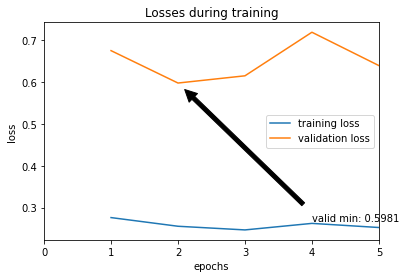

In [ ]:
# XXX - EC22 - 1.0

# Representa en una gráfica los datos de las pérdidas de entrenamiento y
# validación. Carga estos datos del archivo .var correspondiente si no has
# realizado el entrenamiento en esta sesión.
# Start_________________________________________________________________________
# Carga los datos de simulación (si procede) 

#model_trasnfer, training_data_mt = load_tr_model(mt_save_name, model_transfer, optimizer_transfer, custom_classifier)

x = range(1, 1 + len(training_data_mt[0]))
tr_losses, vl_losses = training_data_mt[0], training_data_mt[1]
tr_losses = list(map( lambda x : x.cpu().numpy(),tr_losses))
vl_losses = list(map( lambda x : x.cpu().numpy(),vl_losses))
tr_max, tr_min = np.max(tr_losses), np.min(tr_losses)
epoch_min = 1 + np.argmin(vl_losses)
val_min = np.min(vl_losses)

plt.plot(x, tr_losses, label='training loss')
plt.plot(x, vl_losses, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Losses during training")
plt.legend()
plt.annotate('valid min: {:.4f}'.format(val_min), xy=(epoch_min, val_min),
             xytext=(round(0.75 * len(tr_losses)), 3*(tr_max - tr_min)/4 + tr_min),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.xlim(0, len(tr_losses))
plt.show()

# End___________________________________________________________________________

**PREGUNTA sobre EC20 (2 puntos):** Explica e interpreta la gráfica anterior

**Respuesta:** Por espacio de memoria no se hizo un entrenamiento tan extenso, sin embargo se logra visualizar un sobreajuste, dado que los datos de entrenamiento se ven con un error muy pequeño y los datos de validación con un error mucho mayor. Abría que agregar un dropout para corregir un poco este aprendizaje.

A continuación se va a realizar un test al modelo entrenado. Para ejecutar este test utilizarás la función test del archivo `helpers.py`.
Se espera que este modelo entrenado sea capaz de clasificar correctamente mejor que el primero definido en este trabajo. No es objeto de esta práctica conseguir un determinado valor de precisión.

Para cargar el modelo, si lo has entrenado en una sesión anterior, tendrás que usar la función que has definido para tal efecto: `load_tr_model()`

In [ ]:
# XXX - EC23 - 1.0

# Start_________________________________________________________________________
# Asegúrate de tener en model_transfer el mejor modelo entrenado; es decir,
# carga el modelo si no has hecho el entrenamiento en esta sesión. Si has hecho
# el entrenamiento en esta sesión, esto es innecesario
pass
#model_transfer, checkpoint = load_tr_model(mt_save_name, model_transfer, optimizer_transfer, custom_classifier)
# Ejecuta el test
h.test(loaders_scratch,model_transfer,criterion_transfer,TRAIN_ON_GPU )
# End___________________________________________________________________________

Test Loss: 0.596539

Test Accuracy: 85.5% (700/819)


{'accuracy': 85.47008547008546, 'test loss': 0.5965385437011719}

## La aplicación

Finalmente se te pide que elabores una función que reciba como entrada un path a un archivo de imagen de una flor y devuelva como salida el nombre de esa especie de flor.

Recuerda que al grabar el modelo has incorporado una propiedad llamada `class_to_idx`, que no es más que un diccionario que mapea los nombres de las carpetas (como clave) hacia el número de salida del modelo (como índice).

Antes de programar la función `predict_flower` te conviene definir un nuevo diccionario que sea capaz de mapear el índice de salida del modelo (como clave) hacia el nombre de la flor (como valor). Para ello tendrás que usar la propiedad class_to_idx y el archivo cat_to_name.

Recuerda que class_to_idx es un diccionario que mapea el nombre de la carpeta usada en el entrenamiento con el índice que identifica una salida concreta del modelo. Por ejemplo: {key='1': value=0}

Por su parte cat_to_name es un diccionario que mapea el nombre de la carpeta usada en el entrenamiento con el nombre de la especie de flor. Por ejemplo: {key='1': value='pink primrose'}

Pues bien, lo que se requiere ahora es un diccionario que pueda partir del índice que identifica una salida del modelo hasta el nombre de la flor; es decir: {key='0': value='pink primrose'}

In [ ]:
# XXX - EC24 - 2.0

# Define la variable 'index_to name' como un diccionario que mapea el índice que
# indica la salida del modelo hacia el nombre de la flor. Esto te será de utilidad
# en la función siguiente

# Start_________________________________________________________________________
index_to_name = {}
idx_to_class = {y: x for x, y in model_transfer.class_to_idx.items()}
for index in range(output_features_class):
  index_to_name.update({index: cat_to_name[idx_to_class[index]]})


# End___________________________________________________________________________

In [ ]:
# XXX - EC25 - 4.0

# Completa la función predict_flower para que tenga la funcionalidad deseada

def predict_flower(img_path, model, index_to_name):
    '''
    Predice la especie de flor

    Entradas:
        -img_path: Path al archivo de imagen de la flor.
        -model: El modelo entrenado.
        -cat_to_name: Diccionario que mapea la salida del modelo al nombre de
            la flor.
        
    Salidas:
        -flower_name: String con el nombre de la flor.
        -prob: Probabilidad asociada a la salida de la red (float)
    '''
    
    # Se carga la imagen
    image = Image.open(img_path)
    
    # Start_____________________________________________________________________
    # Define el normalizador según
    # https://pytorch.org/docs/stable/torchvision/models.html
    x, y = image.size
    izquierda = (x - 224) / 2
    derecha = (x + 224) / 2
    arriba = (y - 224) / 2
    abajo = (y + 224) / 2

    # Haz que 'image' cuadre dimensionalmente con lo que solicita la red.
    image = image.crop((izquierda, arriba, derecha, abajo))
    
    image = np.array(image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std
    #para que la multiplicacion de matrices cuadre
    image = image.transpose(2, 0, 1)
    
    # Concretamente, comprueba que tienes una dimensión para el batch, y ponla
    # si no es así. Pasa también el tensor a la GPU si procede
    image = np.expand_dims(image, axis=0)
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor).to(DEVICE)
  
    # Calcula la salida
    with torch.no_grad():
        out = model.forward(image_tensor)

    
    # Busca el índice de salida con el máximo valor.
    #out_np = out.cpu().numpy()[0]

    index_flor = int(torch.argmax(out).cpu().numpy())
    
    
    # Calcula la certeza del sistema (la probabilidad indicada por la
    # salida de la red)

    #como no la hemos usado en nuestro modelo, invocamos la capa logsoftmax ahora
    logSoftMax = nn.LogSoftmax(dim=1)

    prob = torch.max(torch.exp(logSoftMax(out)))

    # Obtén el nombre buscado
    flower_name = index_to_name[index_flor]
    # End_______________________________________________________________________
    
    return flower_name, prob

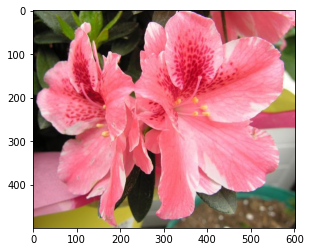

True flower class: azalea
Predicted flower class: azalea with probability 0.9838




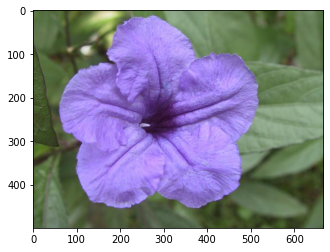

True flower class: mexican petunia
Predicted flower class: poinsettia with probability 0.9892




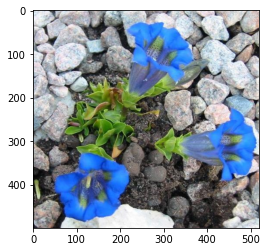

True flower class: stemless gentian
Predicted flower class: poinsettia with probability 0.7055




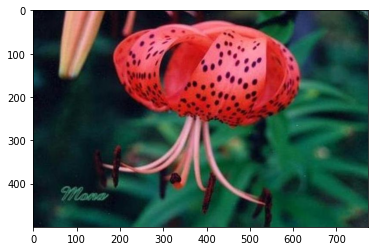

True flower class: tiger lily
Predicted flower class: tiger lily with probability 0.9999




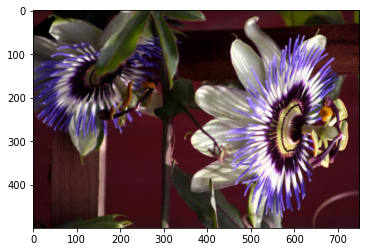

True flower class: passion flower
Predicted flower class: ball moss with probability 0.8216




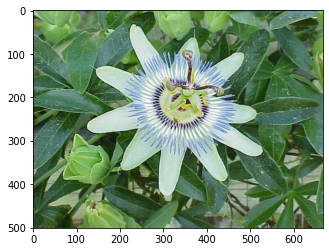

True flower class: passion flower
Predicted flower class: passion flower with probability 1.0000




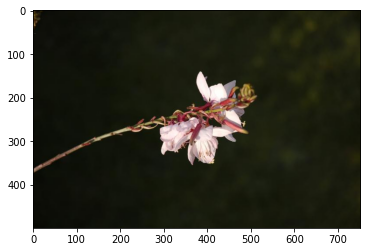

True flower class: gaura
Predicted flower class: gaura with probability 0.8638




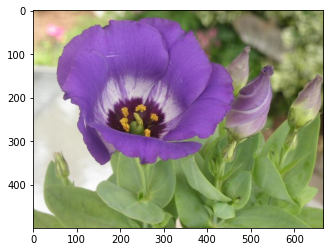

True flower class: bolero deep blue
Predicted flower class: bolero deep blue with probability 0.9901




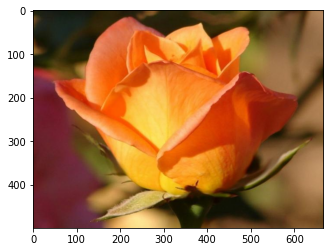

True flower class: rose
Predicted flower class: sword lily with probability 0.9952




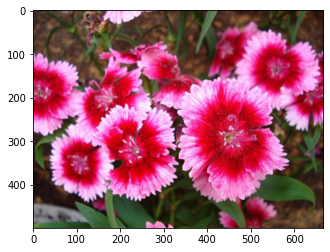

True flower class: sweet william
Predicted flower class: sweet william with probability 1.0000




In [ ]:
# Ejecuta esta celda para comprobar que efectivamente tu función obtiene el
# nombre correcto de la especie de flor, con indicación de la probabilidad
# asociada. No tienes que cambiar nada en esta celda.

from glob import glob
image_path_arr = random.choices(np.array(glob("flower_data/test/*/*")), k=10)

for image in image_path_arr:
    flower, prob = predict_flower(image, model_transfer, index_to_name)

    # Lee la imagen
    img = cv2.imread(image)

    # Muestra la imagen
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

    # Se escribe el nombre de la especie de flor, tanto la real como la que se
    # predice y la probabilidad que considera el modelo de que la flor sea la
    # indicada
    print('True flower class: {}'.format(cat_to_name[image.split('/')[2]]))
    print('Predicted flower class: {} with probability {:.4f}'.format(flower, float(prob)))
    print('\n')

Se testea el código teniendo en cuenta la configuración CrossEntropyLoss() y utilizando como entrada logSoftMax teniendo encuenta la información encontrada en este artículo. Sin embargo el tex arrojó mayor error cuando se reduce el batch_size de 512 a 102 https://arxiv.org/abs/1612.02295

In [ ]:
ms_save_name2='model_scratch2.pt'
criterion_scratch2 =  nn.CrossEntropyLoss()
startT = time.monotonic()
n_epochs=70
model_scratch2, training_data2 = train(n_epochs, loaders_scratch, model_scratch2, optimizer_scratch, criterion_scratch2,filename=ms_save_name2)
endT = time.monotonic()
print(timedelta(seconds=endT-startT))

h.test(loaders_scratch, model_scratch2,criterion_scratch2, TRAIN_ON_GPU)

Epoch: 1  Training Loss: 302.445830  Validation Loss: 41.848967   Time: 42.9
Validation loss decreased from 41.848967 to 41.848967 in epoch 1. Saved!
Epoch: 2  Training Loss: 302.407299  Validation Loss: 41.680507   Time: 42.9
Validation loss decreased from 41.680507 to 41.680507 in epoch 2. Saved!
Epoch: 3  Training Loss: 302.325590  Validation Loss: 41.690669   Time: 43.4
Epoch: 4  Training Loss: 302.218594  Validation Loss: 41.496377   Time: 44.3
Validation loss decreased from 41.496377 to 41.496377 in epoch 4. Saved!
Epoch: 5  Training Loss: 302.426266  Validation Loss: 41.794512   Time: 43.7
Epoch: 6  Training Loss: 302.376114  Validation Loss: 41.902066   Time: 43.4
Epoch: 7  Training Loss: 302.458251  Validation Loss: 41.710598   Time: 43.0
Epoch: 8  Training Loss: 302.522603  Validation Loss: 41.770047   Time: 42.6
Epoch: 9  Training Loss: 302.283715  Validation Loss: 41.778116   Time: 44.0
Epoch: 10  Training Loss: 302.338933  Validation Loss: 41.863429   Time: 44.6
Epoch: 11 

{'accuracy': 0.9768009768009768, 'test loss': 4.649839878082275}